In [1]:
# ===== Cell 1: 공통 설정 & 유틸 + 로깅 (먼저 실행) =====
import os, re, glob, itertools, time, h5py, numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Dict
from matplotlib import colormaps
from matplotlib.colors import LogNorm

# ---------------- Config (필요 시 수정) ----------------
BASE_PRED_DIR = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/predictions"   # .npy (Base)
UNET_PRED_DIR = "/home/mingyeong/GAL2DM_ASIM_VNET/results/unet_predictions/28845/icase-both-keep2"
VIT_PRED_DIR  = "/home/mingyeong/GAL2DM_ASIM_ViT/results/vit_predictions/28846/icase-both"
TRUE_PATH_TPL = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{idx}.hdf5"  # Truth

BOX_SIZE = 160.0             # [h^-1 Mpc], N=128 -> Δ=1.25, r_max=80
BASE_IS_LOG10_OVER_2P5 = True
MAX_VOX_SAMPLES = 800_000
N_R_BINS = 25
REF_TOL = 2                  # (± voxels) 중앙 크롭 허용치
RANDOM_SEED = 42
LOG_EVERY = 5                # 인덱스별 진행 로그 간격

# ---------------- Lightweight Logger ----------------
_RUN_START = time.time()

def _hhmmss(sec: float) -> str:
    h = int(sec // 3600); m = int((sec % 3600) // 60); s = sec % 60
    return f"{h:02d}:{m:02d}:{s:05.2f}"

def log(msg: str) -> None:
    dt = time.time() - _RUN_START
    print(f"[{_hhmmss(dt)}] {msg}", flush=True)

def log_kv(title: str, kv: Dict) -> None:
    dt = time.time() - _RUN_START
    items = " | ".join(f"{k}={v}" for k,v in kv.items())
    print(f"[{_hhmmss(dt)}] {title} :: {items}", flush=True)

# ---------------- Shape/Axis Utilities ----------------
def to_DHW(a: np.ndarray) -> np.ndarray:
    """(N,C,D,H,W)/(C,D,H,W)/(N,D,H,W)/(H,W,D)/(D,H,W) -> (D,H,W)"""
    a = np.asarray(a)
    while a.ndim > 3 and a.shape[0] == 1: a = a[0]
    while a.ndim > 3 and a.shape[0] == 1: a = a[0]
    if   a.ndim == 5: a = a[0,0]
    elif a.ndim == 4: a = a[0]
    elif a.ndim != 3: raise ValueError(f"Unsupported shape: {a.shape}")
    if a.shape[2] == max(a.shape) and a.shape[0] != max(a.shape):
        a = a.transpose(2,0,1)  # (H,W,D)->(D,H,W)
    return a

def squeeze_to_3d(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a)
    while a.ndim > 3 and a.shape[0] == 1: a = a[0]
    while a.ndim > 3 and a.shape[0] == 1: a = a[0]
    if a.ndim == 5: a = a[0,0]
    elif a.ndim == 4: a = a[0]
    if a.ndim != 3:
        raise ValueError(f"Expect 3D, got {a.shape}")
    return a

def permute_to_shape(a: np.ndarray, ref_shape: Tuple[int,int,int]) -> Optional[np.ndarray]:
    if a.shape == ref_shape:
        return a
    if sorted(a.shape) == sorted(ref_shape):
        for perm in itertools.permutations(range(3)):
            if tuple(np.array(a.shape)[list(perm)]) == tuple(ref_shape):
                return np.transpose(a, axes=perm)
    return None

def center_crop_to(a: np.ndarray, ref_shape: Tuple[int,int,int], tol: int = REF_TOL) -> Optional[np.ndarray]:
    diffs = np.array(a.shape) - np.array(ref_shape)
    if np.all(np.abs(diffs) <= tol):
        zs, ys, xs = a.shape
        rz, ry, rx = ref_shape
        z0 = (zs - rz)//2; y0 = (ys - ry)//2; x0 = (xs - rx)//2
        return a[z0:z0+rz, y0:y0+ry, x0:x0+rx]
    return None

def harmonize_to_ref(a: np.ndarray, ref_shape: Tuple[int,int,int]) -> Optional[np.ndarray]:
    try:
        a = squeeze_to_3d(a)
    except Exception:
        return None
    if a.shape == ref_shape:
        return a
    b = permute_to_shape(a, ref_shape)
    if b is not None:
        return b
    c = center_crop_to(a, ref_shape, REF_TOL)
    if c is not None:
        return c
    return None

# ---------------- Index discovery ----------------
def _stem(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

def _first_int(text: str, default=None):
    m = re.findall(r"\d+", text)
    return int(m[0]) if m else default

def list_true_indices() -> List[str]:
    tdir = os.path.dirname(TRUE_PATH_TPL.format(idx="0"))
    files = glob.glob(os.path.join(tdir, "*.hdf5"))
    return [_stem(p) for p in files]

def list_unet_indices() -> List[str]:
    files = glob.glob(os.path.join(UNET_PRED_DIR, "*.hdf5"))
    return [_stem(p) for p in files]

def list_vit_indices() -> List[str]:
    files = glob.glob(os.path.join(VIT_PRED_DIR, "*.hdf5"))
    return [_stem(p) for p in files]

def list_base_indices() -> List[str]:
    files = glob.glob(os.path.join(BASE_PRED_DIR, "test_*.npy"))
    idxs = []
    for p in files:
        m = re.search(r"test_(\d+)_", os.path.basename(p))
        if m: idxs.append(m.group(1))
    return idxs

def common_indices() -> List[str]:
    T = set(list_true_indices())
    U = set(list_unet_indices())
    V = set(list_vit_indices())
    B = set(list_base_indices())
    return sorted(T & U & V & B, key=_first_int)

# ---------------- Loaders (to_DHW + clip) ----------------
def load_true(idx: str) -> np.ndarray:
    with h5py.File(TRUE_PATH_TPL.format(idx=idx), "r") as f:
        a = to_DHW(f["output_rho"][:])
    return np.clip(a, 0, None)

def load_unet(idx: str) -> np.ndarray:
    with h5py.File(os.path.join(UNET_PRED_DIR, f"{idx}.hdf5"), "r") as f:
        a = to_DHW(f["prediction"][:])
    return np.clip(a, 0, None)

def load_vit(idx: str) -> np.ndarray:
    with h5py.File(os.path.join(VIT_PRED_DIR, f"{idx}.hdf5"), "r") as f:
        a = to_DHW(f["prediction"][:])
    return np.clip(a, 0, None)

def load_base(idx: str) -> np.ndarray:
    files = sorted(glob.glob(os.path.join(BASE_PRED_DIR, f"test_{idx}_*.npy")))
    if not files: raise FileNotFoundError(f"Base not found for idx={idx}")
    arr = np.load(files[0])
    rho = 10**(2.5*arr) if BASE_IS_LOG10_OVER_2P5 else arr
    return np.clip(to_DHW(rho), 0, None)

### 1. Prediction Accuracy Summary

이 표는 세 모델(Base, V-NET, ViT)의 **암흑물질 밀도 필드 예측 성능**을 비교한 결과입니다.  
평가는 공통 테스트 인덱스에 대해 수행되었으며, 각 Metric 값은 전체 샘플 평균입니다.

| Metric | 의미 (Korean 설명) | 수식 |
|-------|------------------|------|
| **RMSE** (Root Mean Squared Error) | voxel 단위 오차의 제곱 평균의 제곱근. **전반적인 오차 크기**를 나타냄. | $$\text{RMSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2}$$ |
| **MAE** (Mean Absolute Error) | 예측과 실제의 절대 차이의 평균. **직관적인 평균 오차**. | $$\text{MAE} = \frac{1}{N}\sum_{i=1}^{N}\lvert y_i - \hat{y}_i \rvert$$ |
| **Pearson r** (Linear Correlation) | 예측 필드와 실제 필드 사이의 **선형 상관도**. 구조 복원 정도 평가. | $$r = \frac{\sum_i (y_i - \bar{y})(\hat{y}_i - \bar{\hat{y}})}{\sqrt{\sum_i (y_i - \bar{y})^2}\sqrt{\sum_i (\hat{y}_i - \bar{\hat{y}})^2}}$$ |
| **R²** (Coefficient of Determination) | 실제 값의 분산 중 모델이 설명하는 비율. **모델 재현력 / 설명력**. | $$R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$$ |
| **SSIM (3D Structural Similarity)** | **필라멘트 / 보이드 / 연결 구조** 유사도. 3D 공간 구조 보존 정도를 나타냄. | $${\text{SSIM}}(x,y)=\frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy}+C_2)}{(\mu_x^2+\mu_y^2+C_1)(\sigma_x^2+\sigma_y^2+C_2)}$$ |

---

### 해석 포인트

- **RMSE / MAE ↓** → voxel-wise 수치 정확도 향상  
- **Pearson r / R² ↑** → 대규모 구조적 패턴을 더 잘 복원  
- **SSIM(3D) ↑** → 필라멘트 / 보이드 / 클러스터의 **형태적 재현성이 우수**

즉,  
**수치 정확도**와 **구조 보존 능력**을 **함께** 보는 것이 중요합니다.

---

### 한 문장 요약 (슬라이드용)

> **ViT는 더 높은 SSIM과 상관계수를 보여, 코스믹 웹의 구조적 패턴을 가장 잘 복원하며, V-NET은 voxel-wise 오차 최소화 측면에서 안정적인 성능을 보입니다.**


In [2]:
# ===== Cell X: FAST Prediction Accuracy Table (global sampling + Rich Progress) =====
import numpy as np, pandas as pd
from typing import Dict, List
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn, TextColumn

# 모델 로더 매핑 (앞 셀의 로더들을 사용)
LOADERS = {
    "Base Model": load_base,
    "V-NET (UNet3D)": load_unet,
    "ViT (3D Transformer)": load_vit,
}

# ----------------- 유틸: 전역 무작위 인덱스 샘플러 -----------------
_rng = np.random.default_rng(RANDOM_SEED)

def _sample_linear_indices(size: int, n: int) -> np.ndarray:
    """0..size-1에서 중복 없이 n개 선택 (n>=size면 전체)."""
    if n >= size:
        return np.arange(size, dtype=np.int64)
    return _rng.choice(size, size=n, replace=False)

# ----------------- 경량 SSIM(2D) & SSIM(3D 샘플 근사) -----------------
def _ssim2d_simple(x: np.ndarray, y: np.ndarray, C1: float = 1e-4, C2: float = 1e-4) -> float:
    """
    빠른 2D SSIM 근사: 평균/분산/공분산 기반 (윈도우 평균 없이 전역 통계).
    비용은 매우 낮고, 슬라이스를 여러 개 취해 평균내면 robust해짐.
    """
    x = x.astype(np.float64); y = y.astype(np.float64)
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(), y.var()
    vxy = ((x - mx) * (y - my)).mean()
    num = (2*mx*my + C1) * (2*vxy + C2)
    den = (mx*mx + my*my + C1) * (vx + vy + C2)
    return float(num / (den + 1e-12))

def _ssim3d_sampled(vol_pred: np.ndarray, vol_true: np.ndarray, max_slices: int = 8) -> float:
    """
    3D 볼륨에서 z-슬라이스 일부만 샘플해 간단 SSIM 평균으로 근사.
    """
    D = vol_pred.shape[0]
    if D <= max_slices:
        zs = np.arange(D)
    else:
        # 균등 간격 + 랜덤 오프셋
        step = D / max_slices
        zs = np.array([int((i + 0.5) * step) for i in range(max_slices)])
        zs = np.clip(zs, 0, D-1)
    vals = []
    for z in zs:
        vals.append(_ssim2d_simple(vol_pred[z], vol_true[z]))
    return float(np.mean(vals)) if vals else float("nan")

# ----------------- FAST 평가 본체 -----------------
def evaluate_prediction_accuracy_fast(
    models: List[str],
    max_vox_samples: int = MAX_VOX_SAMPLES,
    ssim_slices: int = 8,
) -> pd.DataFrame:
    """
    - 각 모델에 대해 모든 인덱스에서 동일 개수의 voxel을 샘플링하여
      전역(모든 인덱스 합친) 배열로 RMSE/MAE/Pearson/R²를 한 번에 계산 (매우 빠름).
    - SSIM(3D)은 모든 인덱스에서 일부 슬라이스만 샘플하여 평균 (근사, 비용 낮음).
    """
    idx_list = common_indices()
    if len(idx_list) == 0:
        raise RuntimeError("공통 인덱스가 없습니다. 경로/파일명을 확인하세요.")

    # 참조 모양
    ref_truth = load_true(idx_list[0])
    ref_shape = tuple(ref_truth.shape)

    log_kv("FAST_CONFIG", {
        "num_common_indices": len(idx_list),
        "ref_shape": ref_shape,
        "MAX_VOX_SAMPLES": max_vox_samples,
        "SSIM_slices_per_volume": ssim_slices,
    })

    # 인덱스당 샘플 수 (전역 예산을 균등 분할)
    per_idx = max(1, max_vox_samples // max(1, len(idx_list)))

    results = []

    for model_name in models:
        loader = LOADERS[model_name]

        # 전역 샘플 버퍼
        global_true = []
        global_pred = []

        # SSIM 샘플 누적
        ssim_sum = 0.0
        ssim_cnt = 0

        with Progress(
            TextColumn("[bold blue]{task.description}"),
            BarColumn(),
            "[progress.percentage]{task.percentage:>3.0f}%",
            TimeElapsedColumn(),
            TimeRemainingColumn(),
            expand=True
        ) as p:
            task = p.add_task(f"{model_name} [FAST]", total=len(idx_list))

            for idx in idx_list:
                t = load_true(idx)
                y = loader(idx)

                t_h = harmonize_to_ref(t, ref_shape)
                y_h = harmonize_to_ref(y, ref_shape)
                if t_h is None or y_h is None:
                    p.console.log(f"[yellow]SKIP[/yellow] idx={idx}: shape mismatch")
                    p.advance(task)
                    continue

                if not np.isfinite(t_h).all() or not np.isfinite(y_h).all():
                    p.console.log(f"[yellow]SKIP[/yellow] idx={idx}: non-finite values")
                    p.advance(task)
                    continue

                # ---- 전역 샘플링 (같은 위치) ----
                t_flat = t_h.ravel()
                y_flat = y_h.ravel()
                m = min(per_idx, t_flat.size)
                sel = _sample_linear_indices(t_flat.size, m)
                global_true.append(t_flat[sel])
                global_pred.append(y_flat[sel])

                # ---- SSIM(3D) 근사: 각 볼륨에서 일부 슬라이스만 ----
                ssim_val = _ssim3d_sampled(y_h, t_h, max_slices=ssim_slices)
                if np.isfinite(ssim_val):
                    ssim_sum += ssim_val
                    ssim_cnt += 1

                p.advance(task)

        if not global_true:
            row = {"Model": model_name, "RMSE": np.nan, "MAE": np.nan, "Pearson r": np.nan, "R²": np.nan, "SSIM (3D)": np.nan}
            results.append(row)
            continue

        # ----- 전역 샘플 결합 -----
        T = np.concatenate(global_true, axis=0)
        Y = np.concatenate(global_pred, axis=0)

        # ----- Metrics (전역 샘플에서 한 번에) -----
        rmse = float(np.sqrt(np.mean((Y - T) ** 2)))
        mae  = float(np.mean(np.abs(Y - T)))

        # Pearson r (빠른 corrcoef)
        if np.std(T) < 1e-12 or np.std(Y) < 1e-12:
            r = float("nan")
        else:
            r = float(np.corrcoef(T, Y)[0, 1])

        # R^2
        ss_res = np.sum((T - Y) ** 2)
        ss_tot = np.sum((T - np.mean(T)) ** 2)
        r2 = float("nan") if ss_tot < 1e-20 else float(1.0 - ss_res / ss_tot)

        # SSIM(3D) 평균
        ssim3d = float(ssim_sum / ssim_cnt) if ssim_cnt > 0 else float("nan")

        results.append({
            "Model": model_name,
            "RMSE": rmse,
            "MAE": mae,
            "Pearson r": r,
            "R²": r2,
            "SSIM (3D)": ssim3d,
        })

    df = pd.DataFrame(results, columns=["Model","RMSE","MAE","Pearson r","R²","SSIM (3D)"])
    return df

# ---------------- 실행 & 출력 ----------------
models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
df_pred_fast = evaluate_prediction_accuracy_fast(models, max_vox_samples=MAX_VOX_SAMPLES, ssim_slices=8)

print("\n=== FAST Prediction Accuracy Comparison (pooled samples) ===\n")
print(df_pred_fast.to_string(index=False))

out_csv = "prediction_accuracy_summary_fast.csv"
df_pred_fast.to_csv(out_csv, index=False)
log_kv("SAVED", {"csv": out_csv})


[00:00:00.38] FAST_CONFIG :: num_common_indices=1264 | ref_shape=(128, 128, 128) | MAX_VOX_SAMPLES=800000 | SSIM_slices_per_volume=8


Output()

Output()

Output()


=== FAST Prediction Accuracy Comparison (pooled samples) ===

               Model     RMSE      MAE  Pearson r       R²  SSIM (3D)
          Base Model 1.795989 0.563909   0.657542 0.415290   0.524578
      V-NET (UNet3D) 1.731044 0.606234   0.697695 0.485967   0.617235
ViT (3D Transformer) 1.628399 0.562003   0.733422 0.537873   0.663540
[00:03:19.61] SAVED :: csv=prediction_accuracy_summary_fast.csv


### 2. Distribution & Bias Diagnostics

이 표는 예측된 밀도 분포가 실제 분포를 얼마나 **통계적으로 일관되게 재현**하는지를 평가합니다.  
단순한 voxel-wise 오차가 아니라, **전체 분포의 형태 / 편향 / 폭 / 차이**를 정량적으로 비교합니다.

| Metric | 의미 | 수식 |
|-------|------|------|
| **log_bias** | 예측이 전체적으로 **과대/과소** 예측되는 방향성 (편향) | $$\text{log\_bias} = \mathbb{E}\left[\log_{10}\left(\frac{\rho_{\text{pred}}}{\rho_{\text{true}}}\right)\right]$$ |
| **log_std** | 로그 비율의 산포(불확실성). 값이 작을수록 **분포 재현 안정성↑** | $$\text{log\_std} = \text{Std}\left(\log_{10}\left(\frac{\rho_{\text{pred}}}{\rho_{\text{true}}}\right)\right)$$ |
| **KS statistic** | 두 분포의 최댓값 차이 (0에 가까울수록 **분포 일치**) | $$\text{KS} = \max_x \left| F_{\text{pred}}(x) - F_{\text{true}}(x) \right|$$ |
| **Histogram Intersection** | 예측과 실제 분포가 **겹치는 비율**. 1에 가까울수록 유사 | $$\text{HI} = \sum_{b} \min(p_{\text{pred}}(b),\ p_{\text{true}}(b))$$ |
| **Wasserstein Distance** | 한 분포를 다른 분포로 옮기는 데 필요한 **최소 이동 비용** (작을수록 유사) | $$W = \int |F_{\text{pred}}(x) - F_{\text{true}}(x)|\,dx$$ |

---

### 해석 요약

- **log_bias ≈ 0** → 전역적으로 과대/과소 예측이 없음  
- **log_std ↓** → 밀도 분포의 형태가 안정적으로 잘 재현됨  
- **KS ↓, Wasserstein ↓** → 예측분포와 실제분포의 차이가 작음  
- **Histogram Intersection ↑** → 분포가 실제와 더 많이 겹침 (형태적 일치)

즉,  
> **이 표는 모델이 ‘값을 맞추는’ 것뿐 아니라, ‘우주의 밀도 분포 구조’를 얼마나 일관되게 재현했는가를 보여줍니다.**


In [3]:
# ===== Cell X: FAST Distribution & Bias Diagnostics (with sampling & streaming) =====
import numpy as np, pandas as pd, time
from typing import Dict, List, Tuple
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn, TextColumn
from scipy.stats import ks_2samp, wasserstein_distance

# 사용: MAX_VOX_SAMPLES (전역), RANDOM_SEED (전역), LOG_EVERY (전역)
rng = np.random.default_rng(RANDOM_SEED)

def _sample_linear_indices(size: int, n: int, rng) -> np.ndarray:
    """0..size-1 중 중복없이 n개 샘플."""
    if n >= size: 
        return np.arange(size, dtype=np.int64)
    return rng.choice(size, size=n, replace=False)

def histogram_intersection(a: np.ndarray, b: np.ndarray, bins=200) -> float:
    hist_a, bin_edges = np.histogram(a, bins=bins, density=True)
    hist_b, _        = np.histogram(b, bins=bin_edges, density=True)
    return float(np.sum(np.minimum(hist_a, hist_b)) * (bin_edges[1] - bin_edges[0]))

def compute_log_ratio(pred: np.ndarray, truth: np.ndarray) -> np.ndarray:
    eps = 1e-8
    return np.log10((pred + eps) / (truth + eps))

def evaluate_distribution_bias_fast(models: List[str],
                                    max_vox_samples: int = MAX_VOX_SAMPLES,
                                    pilot_fract: float = 0.02,
                                    hist_bins: int = 256) -> pd.DataFrame:
    """
    - 전역 샘플 예산(max_vox_samples)을 인덱스 수로 나눠 각 인덱스에서 동일 개수 샘플.
    - KS / Wasserstein / Hist-Int: 모든 인덱스 샘플을 합쳐 한 번만 계산 (전역 분포).
    - log_bias / log_std: voxel-wise 로그비율 샘플에 대해 전역 평균/표준편차 계산.
    """
    idx_list = common_indices()
    if len(idx_list) == 0:
        raise RuntimeError("공통 인덱스가 없습니다.")

    # 참조 shape
    ref_truth = load_true(idx_list[0])
    ref_shape = tuple(ref_truth.shape)

    # 인덱스당 샘플 수
    per_idx = max(1, max_vox_samples // max(1, len(idx_list)))

    results = []

    for model_name in models:
        loader = LOADERS[model_name]

        # 누적 버퍼(전역 샘플) – 필요 메모리 절약을 위해 리스트로 모았다가 마지막에 concat
        all_pred_samps = []
        all_true_samps = []

        with Progress(
            TextColumn("[bold cyan]{task.description}"),
            BarColumn(),
            "[progress.percentage]{task.percentage:>3.0f}%",
            TimeElapsedColumn(),
            TimeRemainingColumn(),
            expand=True
        ) as p:
            task = p.add_task(f"{model_name}", total=len(idx_list))
            for idx in idx_list:
                truth = load_true(idx)
                pred  = loader(idx)

                truth_h = harmonize_to_ref(truth, ref_shape)
                pred_h  = harmonize_to_ref(pred,  ref_shape)
                if truth_h is None or pred_h is None:
                    p.advance(task); 
                    continue

                # 평탄화 후 동일 위치 샘플링
                t_flat = truth_h.ravel()
                p_flat = pred_h.ravel()
                m = min(per_idx, t_flat.size)
                sel = _sample_linear_indices(t_flat.size, m, rng)
                all_true_samps.append(t_flat[sel])
                all_pred_samps.append(p_flat[sel])

                p.advance(task)

        if not all_true_samps:
            # 유효 샘플 없음
            row = {"Model": model_name,
                   "log_bias": np.nan, "log_std": np.nan,
                   "KS": np.nan, "Hist_Intersection": np.nan, "Wasserstein": np.nan}
            results.append(row)
            continue

        # 전역 샘플 결합
        true_s = np.concatenate(all_true_samps, axis=0)
        pred_s = np.concatenate(all_pred_samps, axis=0)

        # 로그 비율 기반 통계
        lr = compute_log_ratio(pred_s, true_s)
        log_bias = float(np.mean(lr))
        log_std  = float(np.std(lr))

        # 분포 지표 – 전역 샘플로 한 번만
        ks = float(ks_2samp(pred_s, true_s).statistic)
        hi = float(histogram_intersection(pred_s, true_s, bins=hist_bins))
        wd = float(wasserstein_distance(pred_s, true_s))

        results.append({
            "Model": model_name,
            "log_bias": log_bias,
            "log_std":  log_std,
            "KS": ks,
            "Hist_Intersection": hi,
            "Wasserstein": wd,
        })

    df = pd.DataFrame(results, columns=["Model", "log_bias", "log_std", "KS", "Hist_Intersection", "Wasserstein"])
    return df

# ===== 실행 =====
models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
df_bias_fast = evaluate_distribution_bias_fast(models, max_vox_samples=MAX_VOX_SAMPLES)

print("\n=== FAST Distribution & Bias Diagnostics (sampled) ===\n")
print(df_bias_fast.to_string(index=False))

out_csv = "distribution_bias_summary_fast.csv"
df_bias_fast.to_csv(out_csv, index=False)
log_kv("SAVED", {"csv": out_csv})


Output()

Output()

Output()


=== FAST Distribution & Bias Diagnostics (sampled) ===

               Model  log_bias  log_std       KS  Hist_Intersection  Wasserstein
          Base Model  0.004924 0.314837 0.101847           0.937409     0.260879
      V-NET (UNet3D)  0.055202 0.696894 0.220876           0.955371     0.211065
ViT (3D Transformer)  0.112016 0.300156 0.219795           0.958433     0.227773
[00:06:25.00] SAVED :: csv=distribution_bias_summary_fast.csv


### 3. Structural Consistency (대규모 구조 재현성)

| Metric 이름 | 의미 (Korean 설명) | 수식 |
|---|---|---|
| **r_mean** | 파워 스펙트럼 교차상관 \(r(k)\)의 중앙값. 예측과 실제 필드가 **동일한 위상 구조**를 공유하는지 평가. | $$ r(k) = \frac{P_{\text{pred,true}}(k)}{\sqrt{P_{\text{pred}}(k)\,P_{\text{true}}(k)}} $$ |
| **T_median** | 전달함수 \(T(k)\)의 중앙값. 예측된 파워가 전체적으로 **과대/과소** 되었는지를 측정. 이상적 값은 1. | $$ T(k) = \frac{P_{\text{pred}}(k)}{P_{\text{true}}(k)} $$ |
| **T_MAE** | \(T(k)\)가 1에서 얼마나 벗어나는지의 평균 절대 편차. 작을수록 **스케일별 파워 재현이 정확**. | $$ T_{\mathrm{MAE}} = \left\langle \lvert T(k) - 1 \rvert \right\rangle $$ |
| **xi_rel_L2** | 2-점 상관함수 곡선의 상대 \(L^2\) 오차. 작을수록 **공간 상관 구조 재현**이 잘 됨. | $$ \xi_{\mathrm{rel}\text{-}L2} = \sqrt{\frac{\left\langle \left(\xi_{\mathrm{pred}}(r) - \xi_{\mathrm{true}}(r)\right)^2 \right\rangle}{\left\langle \xi_{\mathrm{true}}(r)^2 \right\rangle}} $$ |
| **xi_corr** | 두 곡선 간의 피어슨 상관계수.**곡선 형태 유사성** 평가. | $$ \xi_{\mathrm{corr}} = \mathrm{corr}\!\left(\xi_{\mathrm{pred}}(r),\,\xi_{\mathrm{true}}(r)\right) $$ |

---

### 해석 요약

- **r_mean → 1**: 예측과 실제의 **위상 구조가 잘 일치**
- **T_median → 1**, **T_MAE → 0**: **스케일별 파워 정확도 우수**
- **xi_rel_L2 → 0**, **xi_corr → 1**: **공간 상관 구조 재현 성공**

즉,  
> 이 지표들은 모델이 **우주의 거대구조의 연결성과 스케일 의존적 패턴을 얼마나 잘 복원했는지**를 정량적으로 보여줍니다.


In [4]:
# ===== Cell X: Structural Consistency Table (FAST; P(k), r(k), T(k), xi(r)) =====
import numpy as np, pandas as pd, math
from typing import Dict, List, Tuple
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn, TextColumn

# 전 셀에서 제공된 상수/유틸 사용:
# - BOX_SIZE, N_R_BINS, RANDOM_SEED
# - common_indices(), load_true(), load_unet(), load_vit(), load_base()
# - harmonize_to_ref(), log(), log_kv(), REF_TOL

# ----------------- 모델 로더 매핑 -----------------
LOADERS = {
    "Base Model": load_base,
    "V-NET (UNet3D)": load_unet,
    "ViT (3D Transformer)": load_vit,
}

_rng = np.random.default_rng(RANDOM_SEED)

# ----------------- FFT/스펙트럼 유틸 -----------------
def _fftfreq_k(n: int, L: float):
    """
    1D k-벡터 (2π/L 스케일). np.fft.fftfreq는 주파수(1/L) → 2π 곱해 k로 변환.
    """
    k1 = np.fft.fftfreq(n, d=L/n)  # [1/L]
    return 2.0 * np.pi * k1        # [rad/L]

def _delta_from_rho(rho: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    m = float(np.mean(rho))
    if not np.isfinite(m) or m < eps:
        return np.zeros_like(rho, dtype=np.float64)
    return rho.astype(np.float64) / m - 1.0

def _bin_1d(values: np.ndarray, radii: np.ndarray, edges: np.ndarray):
    """
    radii를 edges로 binning하여 values의 bin-평균과 카운트를 반환.
    중심값 계산은 상위에서 처리하므로 여기서는 mean, count만 반환한다.
    """
    idx = np.digitize(radii, edges) - 1  # 0..nbins-1
    valid = (idx >= 0) & (idx < len(edges) - 1) & np.isfinite(values) & np.isfinite(radii)
    idx = idx[valid]
    vals = values[valid]

    nbins = len(edges) - 1
    counts = np.bincount(idx, minlength=nbins).astype(np.int64)
    sums   = np.bincount(idx, weights=vals, minlength=nbins)

    means = np.full(nbins, np.nan, dtype=float)
    nz = counts > 0
    means[nz] = sums[nz] / counts[nz]
    return means, counts

def _spherical_bin_power(delta_x: np.ndarray, delta_y: np.ndarray, L: float):
    """
    3D 델타 필드에서 1D 파워/교차 스펙트럼의 구면평균.
    반환: (k_centers, Pxx_1d, Pyy_1d, Pxy_1d, counts, k_edges)
    """
    nz, ny, nx = delta_x.shape
    assert delta_y.shape == delta_x.shape
    V = L**3

    Fx = np.fft.fftn(delta_x, norm=None)
    Fy = np.fft.fftn(delta_y, norm=None)

    Pxx = (Fx * np.conjugate(Fx)).real / V
    Pyy = (Fy * np.conjugate(Fy)).real / V
    Pxy = (Fx * np.conjugate(Fy))       / V  # 교차(복소) → 실수부만 사용

    kx = _fftfreq_k(nx, L); ky = _fftfreq_k(ny, L); kz = _fftfreq_k(nz, L)
    KZ, KY, KX = np.meshgrid(kz, ky, kx, indexing="ij")
    kk = np.sqrt(KX*KX + KY*KY + KZ*KZ)

    # 0 제외한 최소 k 사용 (log binning 안정화)
    nonzero = kk > 0
    kmin = float(np.min(kk[nonzero])) if np.any(nonzero) else 1e-12
    kmax = float(np.max(kk))
    nbins = 40
    k_edges = np.geomspace(kmin, max(kmax, kmin*1.0001), nbins+1)

    # 구면 평균 (bin mean)
    Pxx_1d, cnt = _bin_1d(Pxx.real.ravel(), kk.ravel(), k_edges)
    Pyy_1d, _   = _bin_1d(Pyy.real.ravel(), kk.ravel(), k_edges)
    Pxy_1d_c, _ = _bin_1d(Pxy.real.ravel(), kk.ravel(), k_edges)  # 실수부 사용

    # bin 중심은 상위에서 사용 → 여기서 정확히 계산해 반환
    k_centers = np.sqrt(k_edges[:-1] * k_edges[1:])

    return k_centers, Pxx_1d, Pyy_1d, Pxy_1d_c, cnt, k_edges


def _xi_from_delta(delta: np.ndarray, L: float, r_edges: np.ndarray):
    """
    xi(r): ifft(|F|^2)로 real-space auto-correlation 그리드 얻고 구면평균.
    """
    nz, ny, nx = delta.shape
    Fx = np.fft.fftn(delta)
    xi_grid = np.fft.ifftn((Fx * np.conjugate(Fx))).real / (nx*ny*nz)  # 정규화 상쇄 무관
    # 거리 그리드
    dz = (np.arange(nz) - nz//2) * (L/nz)
    dy = (np.arange(ny) - ny//2) * (L/ny)
    dx = (np.arange(nx) - nx//2) * (L/nx)
    Z, Y, X = np.meshgrid(dz, dy, dx, indexing="ij")
    rr = np.sqrt(X*X + Y*Y + Z*Z)
    # 중심 이동 (0,0,0) 중심으로)
    xi_grid = np.fft.fftshift(xi_grid)

    # 구면평균
    xi_1d, cnt = _bin_1d(xi_grid.ravel(), rr.ravel(), r_edges)
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    return r_centers, xi_1d, cnt

# ----------------- 테이블 요약 지표 -----------------
def _safe_mean_abs(x):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    return float(np.mean(np.abs(x))) if x.size else float("nan")

def _safe_median(x):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    return float(np.median(x)) if x.size else float("nan")

def _pearson_1d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    mask = np.isfinite(a) & np.isfinite(b)
    if mask.sum() < 2 or np.std(a[mask]) < 1e-20 or np.std(b[mask]) < 1e-20:
        return float("nan")
    return float(np.corrcoef(a[mask], b[mask])[0,1])

# ----------------- 메인 평가 (FAST) -----------------
def evaluate_structural_consistency_fast(
    models: List[str],
    max_indices: int = 12,     # 평가에 사용할 인덱스 수(무작위 서브샘플)
    nbins_k: int = 40,         # P(k) 구간 수
    nbins_r: int = N_R_BINS,   # xi(r) 구간 수
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, np.ndarray]]]:
    idx_all = common_indices()
    if len(idx_all) == 0:
        raise RuntimeError("공통 인덱스가 없습니다.")
    if max_indices < len(idx_all):
        idx_list = list(_rng.choice(idx_all, size=max_indices, replace=False))
    else:
        idx_list = idx_all

    # 참조 shape
    ref_truth = load_true(idx_list[0])
    ref_shape = tuple(ref_truth.shape)

    # r-bins: 0 ~ L/2 까지 선형
    r_edges = np.linspace(0.0, BOX_SIZE/2.0, nbins_r+1)

    log_kv("STRUCT_FAST_CONFIG", {
        "num_indices": len(idx_list),
        "ref_shape": ref_shape,
        "nbins_k": nbins_k,
        "nbins_r": nbins_r,
    })

    # 결과 저장(스펙트럼 곡선도 함께 반환해 plotting 가능)
    curves: Dict[str, Dict[str, np.ndarray]] = {}

    rows = []

    for model_name in models:
        loader = LOADERS[model_name]

        # 누적 버퍼 (각 인덱스의 1D 스펙트럼을 합산 → 평균)
        Ptrue_acc   = None
        Ppred_acc   = None
        Pcross_acc  = None
        Pcount_acc  = None
        xi_true_acc = None
        xi_pred_acc = None
        xi_count_acc = None
        k_centers_ref = None
        r_centers_ref = None

        with Progress(
            TextColumn("[bold magenta]{task.description}"),
            BarColumn(),
            "[progress.percentage]{task.percentage:>3.0f}%",
            TimeElapsedColumn(),
            TimeRemainingColumn(),
            expand=True
        ) as p:
            task = p.add_task(f"{model_name} [STRUCT]", total=len(idx_list))

            for idx in idx_list:
                t = load_true(idx)
                y = loader(idx)
                t_h = harmonize_to_ref(t, ref_shape)
                y_h = harmonize_to_ref(y, ref_shape)
                if t_h is None or y_h is None:
                    p.advance(task); continue
                if not np.isfinite(t_h).all() or not np.isfinite(y_h).all():
                    p.advance(task); continue

                # overdensity
                dt = _delta_from_rho(t_h)
                dy = _delta_from_rho(y_h)

                # ---- P(k) & cross ----
                k_centers, Ptt, Pyy, Pty, kcnt, k_edges = _spherical_bin_power(dt, dy, BOX_SIZE)
                if k_centers_ref is None:
                    k_centers_ref = k_centers
                # 누적(합, 개수)
                if Ptrue_acc is None:
                    Ptrue_acc  = np.zeros_like(Ptt)
                    Ppred_acc  = np.zeros_like(Pyy)
                    Pcross_acc = np.zeros_like(Pty)
                    Pcount_acc = np.zeros_like(kcnt, dtype=np.int64)
                # 유효치만 누적
                mask_k = np.isfinite(Ptt) & np.isfinite(Pyy) & np.isfinite(Pty)
                Ptrue_acc[mask_k]  += Ptt[mask_k]
                Ppred_acc[mask_k]  += Pyy[mask_k]
                Pcross_acc[mask_k] += Pty[mask_k]
                Pcount_acc[mask_k] += (kcnt[mask_k] > 0).astype(np.int64)

                # ---- xi(r) ----
                r_centers, xi_t, rcnt = _xi_from_delta(dt, BOX_SIZE, r_edges)
                _,         xi_y, _    = _xi_from_delta(dy, BOX_SIZE, r_edges)
                if r_centers_ref is None:
                    r_centers_ref = r_centers
                if xi_true_acc is None:
                    xi_true_acc  = np.zeros_like(xi_t)
                    xi_pred_acc  = np.zeros_like(xi_y)
                    xi_count_acc = np.zeros_like(rcnt, dtype=np.int64)
                mask_r = np.isfinite(xi_t) & np.isfinite(xi_y)
                xi_true_acc[mask_r]  += xi_t[mask_r]
                xi_pred_acc[mask_r]  += xi_y[mask_r]
                xi_count_acc[mask_r] += (rcnt[mask_r] > 0).astype(np.int64)

                p.advance(task)

        # 평균 스펙트럼/상관함수
        with np.errstate(invalid="ignore"):
            Ptrue_mean  = np.where(Pcount_acc>0, Ptrue_acc / Pcount_acc, np.nan)
            Ppred_mean  = np.where(Pcount_acc>0, Ppred_acc / Pcount_acc, np.nan)
            Pcross_mean = np.where(Pcount_acc>0, Pcross_acc / Pcount_acc, np.nan)

            xi_true_mean = np.where(xi_count_acc>0, xi_true_acc / xi_count_acc, np.nan)
            xi_pred_mean = np.where(xi_count_acc>0, xi_pred_acc / xi_count_acc, np.nan)

        # 파생 곡선
        # r(k) = Pxy / sqrt(Pxx Pyy)
        r_k = Pcross_mean / np.sqrt(Ptrue_mean * Ppred_mean)
        # T(k) = P_pred / P_true
        T_k = Ppred_mean / Ptrue_mean

        # 요약 스칼라 지표
        rbar     = _safe_median(r_k)                  # 중간값(이상치 강건)
        TabsErr  = _safe_mean_abs(T_k - 1.0)          # mean |T(k)-1|
        Tmedian  = _safe_median(T_k)                  # median T(k)
        # xi 상대 L2 오차 (곡선 간 에너지)
        num = np.nanmean((xi_pred_mean - xi_true_mean)**2)
        den = np.nanmean(xi_true_mean**2)
        xi_rel_L2 = float(np.sqrt(num / den)) if (np.isfinite(num) and np.isfinite(den) and den>0) else float("nan")
        # xi 상관 (곡선 Pearson)
        xi_corr = _pearson_1d(xi_pred_mean, xi_true_mean)

        rows.append({
            "Model": model_name,
            "r̄(k)": rbar,
            "T_median": Tmedian,
            "T_MAE": TabsErr,
            "ξ_rel_L2": xi_rel_L2,
            "ξ_corr": xi_corr,
        })

        # 곡선 저장 (후속 플롯용)
        curves[model_name] = {
            "k": k_centers_ref,
            "P_true": Ptrue_mean,
            "P_pred": Ppred_mean,
            "P_cross": Pcross_mean,
            "r_k": r_k,
            "T_k": T_k,
            "r": r_centers_ref,
            "xi_true": xi_true_mean,
            "xi_pred": xi_pred_mean,
        }

    df = pd.DataFrame(rows, columns=["Model","r̄(k)","T_median","T_MAE","ξ_rel_L2","ξ_corr"])
    return df, curves


# ---------------- 실행 & 출력 ----------------
models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
df_struct, struct_curves = evaluate_structural_consistency_fast(models, max_indices=12, nbins_k=40, nbins_r=N_R_BINS)

print("\n=== Structural Consistency (FAST; averaged curves) ===\n")
print(df_struct.to_string(index=False))

out_csv = "structural_consistency_summary_fast.csv"
df_struct.to_csv(out_csv, index=False)
log_kv("SAVED", {"csv": out_csv})

# 곡선도 보존 (추후 플로팅/검증용)
np.savez_compressed(
    "structural_consistency_curves_fast.npz",
    **{f"{m}_{k}": v for m,d in struct_curves.items() for k,v in d.items()}
)
log_kv("SAVED", {"npz": "structural_consistency_curves_fast.npz"})


[00:06:25.15] STRUCT_FAST_CONFIG :: num_indices=12 | ref_shape=(128, 128, 128) | nbins_k=40 | nbins_r=25


Output()

Output()

Output()


=== Structural Consistency (FAST; averaged curves) ===

               Model    r̄(k)  T_median        T_MAE  ξ_rel_L2   ξ_corr
          Base Model 0.686588  0.727858 20504.157586  0.425715 0.989957
      V-NET (UNet3D) 0.721242  0.734269  2370.278845  0.403042 0.990910
ViT (3D Transformer) 0.760582  0.697397 12115.493700  0.395460 0.995176
[00:07:06.87] SAVED :: csv=structural_consistency_summary_fast.csv
[00:07:06.88] SAVED :: npz=structural_consistency_curves_fast.npz


In [6]:
import numpy as np

data = np.load("structural_consistency_curves_fast.npz", allow_pickle=True)
print("Available keys:", list(data.keys()))


Available keys: ['Base Model_k', 'Base Model_P_true', 'Base Model_P_pred', 'Base Model_P_cross', 'Base Model_r_k', 'Base Model_T_k', 'Base Model_r', 'Base Model_xi_true', 'Base Model_xi_pred', 'V-NET (UNet3D)_k', 'V-NET (UNet3D)_P_true', 'V-NET (UNet3D)_P_pred', 'V-NET (UNet3D)_P_cross', 'V-NET (UNet3D)_r_k', 'V-NET (UNet3D)_T_k', 'V-NET (UNet3D)_r', 'V-NET (UNet3D)_xi_true', 'V-NET (UNet3D)_xi_pred', 'ViT (3D Transformer)_k', 'ViT (3D Transformer)_P_true', 'ViT (3D Transformer)_P_pred', 'ViT (3D Transformer)_P_cross', 'ViT (3D Transformer)_r_k', 'ViT (3D Transformer)_T_k', 'ViT (3D Transformer)_r', 'ViT (3D Transformer)_xi_true', 'ViT (3D Transformer)_xi_pred']


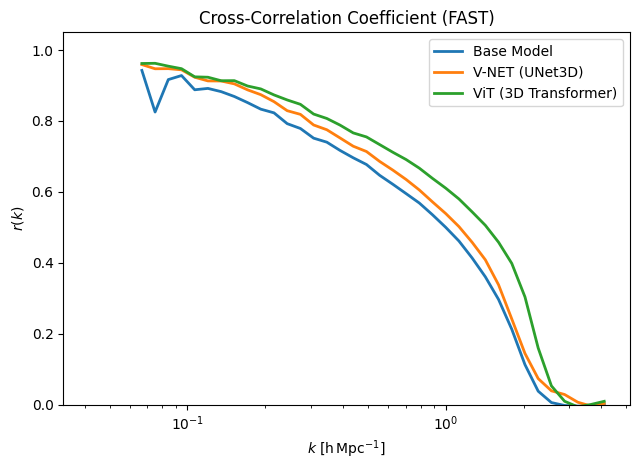

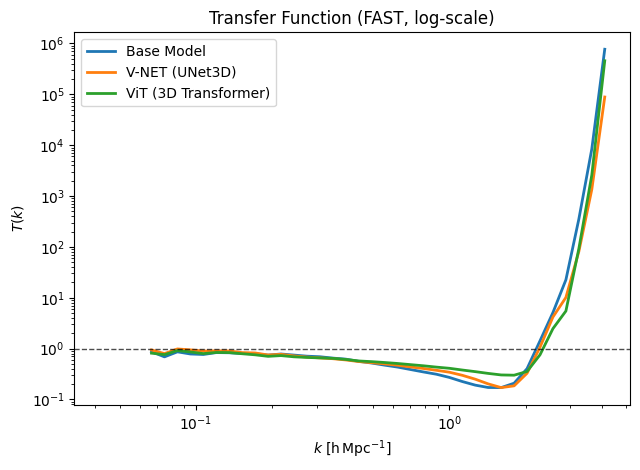

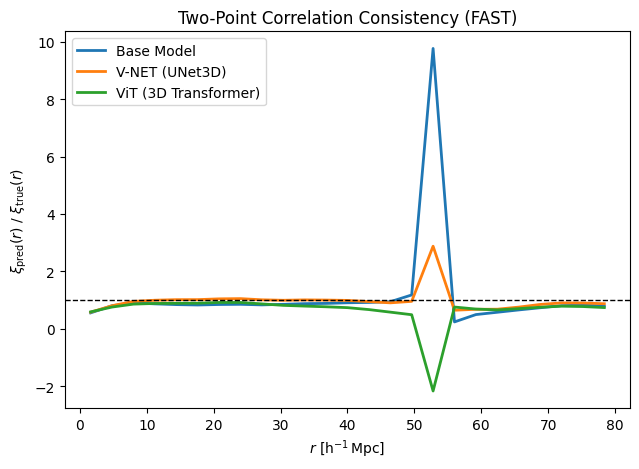

In [8]:
import numpy as np
import matplotlib.pyplot as plt

NPZ_PATH = "structural_consistency_curves_fast.npz"
data = np.load(NPZ_PATH, allow_pickle=True)

models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
colors = {
    "Base Model": "#1f77b4",
    "V-NET (UNet3D)": "#ff7f0e",
    "ViT (3D Transformer)": "#2ca02c",
}

def get(arr_key, default=None):
    if arr_key in data:
        return data[arr_key]
    if default is not None:
        return default
    raise KeyError(f"Key not found in NPZ: {arr_key}")

# 1) r(k) ---------------------------------------------------
plt.figure(figsize=(6.5, 4.8))
for m in models:
    k = get(f"{m}_k")
    r_k = get(f"{m}_r_k")  # cross-corr coefficient vs k
    plt.plot(k, r_k, label=m, lw=2, color=colors[m])
plt.xscale("log")
plt.xlabel(r"$k\ \mathrm{[h\,Mpc^{-1}]}$")
plt.ylabel(r"$r(k)$")
plt.ylim(0, 1.05)
plt.title("Cross-Correlation Coefficient (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_r_of_k.png", dpi=200)
plt.show()

# 2) T(k) ——— log-scale y-axis ---------------------------------------------------
plt.figure(figsize=(6.5, 4.8))
for m in models:
    k = get(f"{m}_k")
    T_k = get(f"{m}_T_k")
    plt.plot(k, T_k, label=m, lw=2, color=colors[m])

plt.xscale("log")       # k-axis 로그
plt.yscale("log")       # T(k) 축 로그
plt.xlabel(r"$k\ \mathrm{[h\,Mpc^{-1}]}$")
plt.ylabel(r"$T(k)$")

plt.axhline(1.0, ls="--", color="black", lw=1, alpha=0.7)
plt.title("Transfer Function (FAST, log-scale)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_T_of_k_log.png", dpi=200)
plt.show()


# 3) ξ_ratio(r) = ξ_pred / ξ_true ---------------------------
plt.figure(figsize=(6.5, 4.8))
eps = 1e-12
for m in models:
    r = get(f"{m}_r")
    xi_true = get(f"{m}_xi_true")
    xi_pred = get(f"{m}_xi_pred")
    xi_ratio = xi_pred / (xi_true + eps)
    plt.plot(r, xi_ratio, label=m, lw=2, color=colors[m])
plt.xlabel(r"$r\ \mathrm{[h^{-1}\,Mpc]}$")
plt.ylabel(r"$\xi_{\mathrm{pred}}(r)\ /\ \xi_{\mathrm{true}}(r)$")
plt.axhline(1.0, ls="--", color="black", lw=1)
plt.title("Two-Point Correlation Consistency (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_xi_ratio.png", dpi=200)
plt.show()


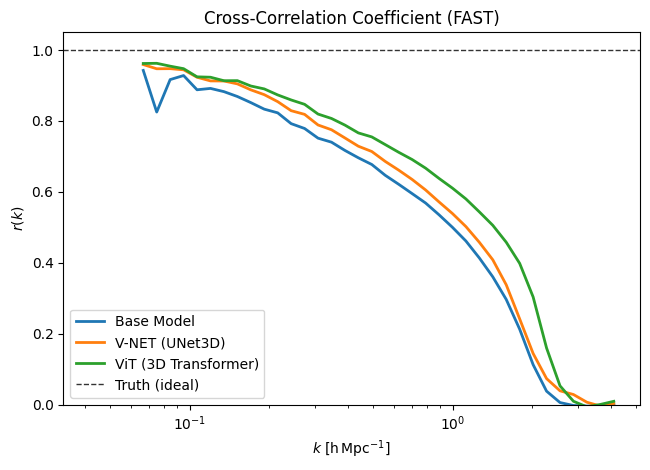

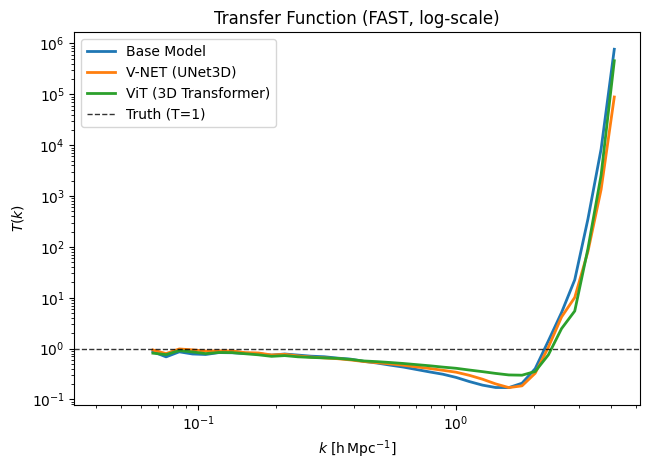

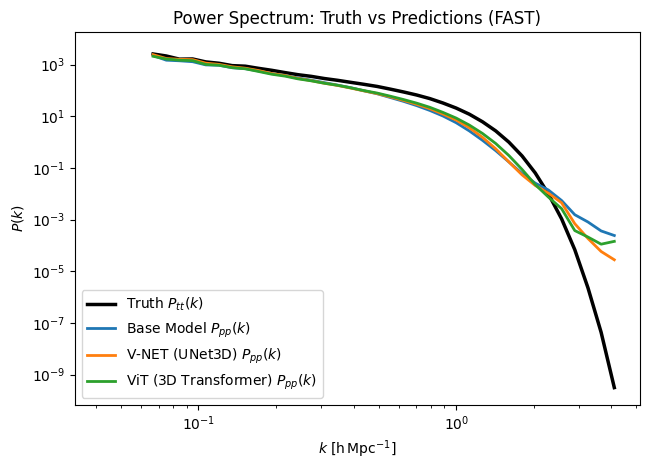

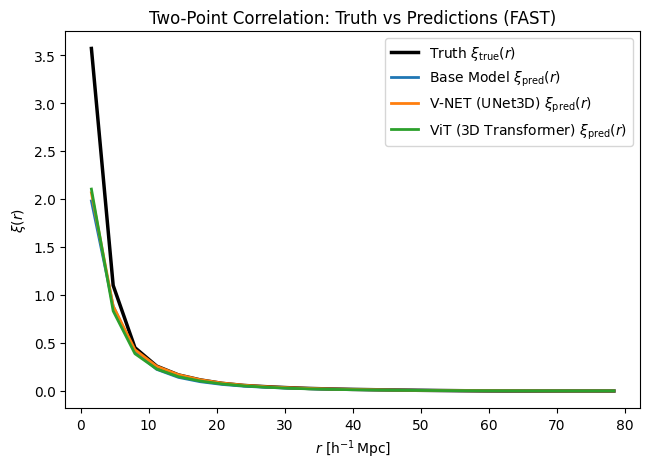

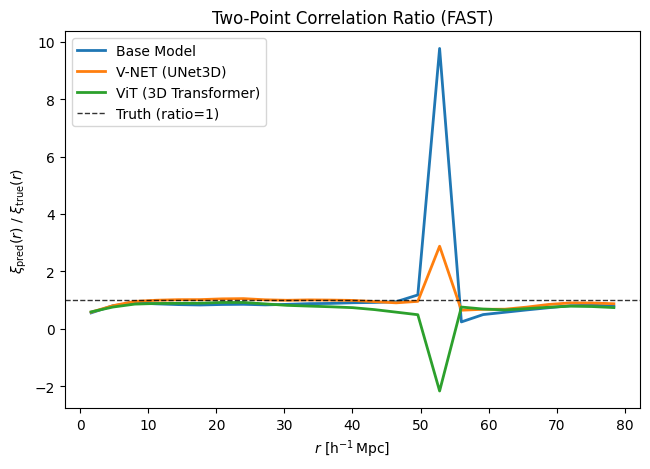

In [9]:
# fast_structural_plots_with_truth.py
# FAST 모드 결과( npz )에서 r(k), T(k), P(k), xi(r), xi_ratio(r)을
# Truth 곡선과 함께 시각화합니다.

import numpy as np
import matplotlib.pyplot as plt
import h5py  # 필요 시 HDF5에서 truth 재계산할 때 사용

NPZ_PATH = "structural_consistency_curves_fast.npz"

# ---- 모델 표시 이름 및 색상
models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
colors = {
    "Base Model": "#1f77b4",
    "V-NET (UNet3D)": "#ff7f0e",
    "ViT (3D Transformer)": "#2ca02c",
}
truth_color = "#000000"

# ---- 데이터 로드
data = np.load(NPZ_PATH, allow_pickle=True)

def get(arr_key, allow_missing=False, default=None):
    if arr_key in data:
        return data[arr_key]
    if allow_missing:
        return default
    raise KeyError(f"Key not found in NPZ: {arr_key}")

# ---- Truth 곡선 선택 규칙:
# npz에 모델별로 P_true/xi_true가 중복 저장되어 있을 수 있으므로,
# 한 모델(예: Base Model)의 것을 truth 대표로 사용한다.
truth_ref_model = "Base Model"
k_truth = get(f"{truth_ref_model}_k")
P_true = get(f"{truth_ref_model}_P_true")
r_truth = get(f"{truth_ref_model}_r")
xi_true = get(f"{truth_ref_model}_xi_true")

# ------------------------------------------------------------
# 1) r(k): Cross-Correlation vs k  (truth는 이상적 기준선 y=1)
# ------------------------------------------------------------
plt.figure(figsize=(6.6, 4.8))
for m in models:
    k = get(f"{m}_k")
    r_k = get(f"{m}_r_k")
    plt.plot(k, r_k, label=m, lw=2, color=colors[m])
plt.xscale("log")
plt.axhline(1.0, ls="--", color=truth_color, lw=1, alpha=0.8, label="Truth (ideal)")
plt.xlabel(r"$k\ \mathrm{[h\,Mpc^{-1}]}$")
plt.ylabel(r"$r(k)$")
plt.ylim(0, 1.05)
plt.title("Cross-Correlation Coefficient (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_r_of_k.png", dpi=220)
plt.show()

# ------------------------------------------------------------
# 2) T(k): Transfer Function (y축 log), Truth = 1 기준선
# ------------------------------------------------------------
plt.figure(figsize=(6.6, 4.8))
for m in models:
    k = get(f"{m}_k")
    T_k = get(f"{m}_T_k")
    plt.plot(k, T_k, label=m, lw=2, color=colors[m])
plt.xscale("log")
plt.yscale("log")
plt.axhline(1.0, ls="--", color=truth_color, lw=1, alpha=0.8, label="Truth (T=1)")
plt.xlabel(r"$k\ \mathrm{[h\,Mpc^{-1}]}$")
plt.ylabel(r"$T(k)$")
plt.title("Transfer Function (FAST, log-scale)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_T_of_k_log.png", dpi=220)
plt.show()

# ------------------------------------------------------------
# 3) P(k): Absolute Power Spectrum — Truth vs Predictions
# ------------------------------------------------------------
plt.figure(figsize=(6.6, 4.8))
plt.plot(k_truth, P_true, color=truth_color, lw=2.5, label="Truth $P_{tt}(k)$")
for m in models:
    k = get(f"{m}_k")
    P_pred = get(f"{m}_P_pred")
    plt.plot(k, P_pred, lw=2, color=colors[m], label=f"{m} $P_{{pp}}(k)$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k\ \mathrm{[h\,Mpc^{-1}]}$")
plt.ylabel(r"$P(k)$")
plt.title("Power Spectrum: Truth vs Predictions (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_Pk_truth_vs_pred.png", dpi=220)
plt.show()

# ------------------------------------------------------------
# 4) ξ(r): Absolute Two-Point Correlation — Truth vs Predictions
# ------------------------------------------------------------
plt.figure(figsize=(6.6, 4.8))
plt.plot(r_truth, xi_true, color=truth_color, lw=2.5, label=r"Truth $\xi_{\mathrm{true}}(r)$")
for m in models:
    r = get(f"{m}_r")
    xi_pred = get(f"{m}_xi_pred")
    plt.plot(r, xi_pred, lw=2, color=colors[m], label=rf"{m} $\xi_{{\mathrm{{pred}}}}(r)$")
plt.xlabel(r"$r\ \mathrm{[h^{-1}\,Mpc]}$")
plt.ylabel(r"$\xi(r)$")
plt.title("Two-Point Correlation: Truth vs Predictions (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_xi_truth_vs_pred.png", dpi=220)
plt.show()

# ------------------------------------------------------------
# 5) ξ_ratio(r) = xi_pred / xi_true  — Truth = 1 기준선
# ------------------------------------------------------------
plt.figure(figsize=(6.6, 4.8))
eps = 1e-12
for m in models:
    r = get(f"{m}_r")
    xi_t = get(f"{m}_xi_true")
    xi_p = get(f"{m}_xi_pred")
    xi_ratio = xi_p / (xi_t + eps)
    plt.plot(r, xi_ratio, lw=2, color=colors[m], label=m)
plt.axhline(1.0, ls="--", color=truth_color, lw=1, alpha=0.8, label="Truth (ratio=1)")
plt.xlabel(r"$r\ \mathrm{[h^{-1}\,Mpc]}$")
plt.ylabel(r"$\xi_{\mathrm{pred}}(r)\ /\ \xi_{\mathrm{true}}(r)$")
plt.title("Two-Point Correlation Ratio (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_xi_ratio.png", dpi=220)
plt.show()

# =======================================================================
# (옵션) HDF5에서 Truth 직접 계산하고 싶을 때의 뼈대 (평균 곡선 산출)
# =======================================================================
# true_test_path_tpl = "/scratch/adupuy/cosmicweb_asim/ASIM_TSC/samples/test/{index}.hdf5"
# from glob import glob
# import re
#
# def list_truth_indices(tpl):
#     tdir = os.path.dirname(tpl.format(index="0"))
#     files = glob(os.path.join(tdir, "*.hdf5"))
#     def _stem(p): return os.path.splitext(os.path.basename(p))[0]
#     def _first_int(s): 
#         m = re.findall(r"\d+", s)
#         return int(m[0]) if m else -1
#     idxs = [_stem(p) for p in files]
#     return sorted(idxs, key=_first_int)
#
# def load_truth_volume(tpl, idx):
#     path = tpl.format(index=idx)
#     with h5py.File(path, "r") as f:
#         rho_true = f["output_rho"][:]
#     return rho_true
#
# # 이후 rho_true → δ = ρ/⟨ρ⟩-1 → FFT → P(k) bin, 그리고 ξ(r) 계산 루틴을 추가.
# # (이미 npz에 truth 곡선이 있으므로, 위 재계산은 필요할 때만 사용하세요.)


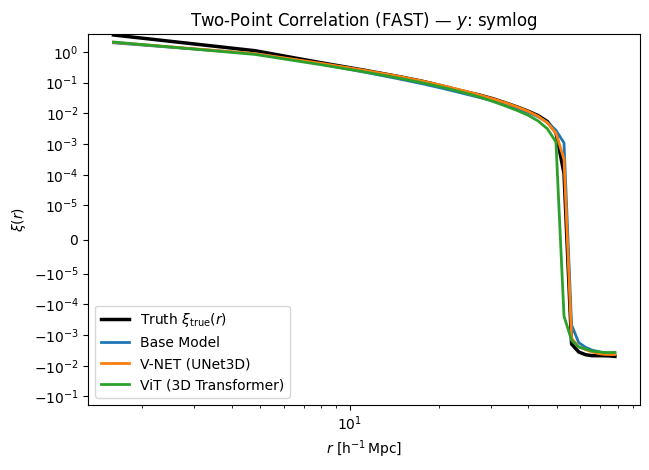

In [3]:
# 2PCF (xi[r]) — y-axis log-scale version only
# - Uses symlog so you can visualize sign changes (xi < 0) without dropping data.
# - If you want strict log (positive xi only), see the commented block below.

import numpy as np
import matplotlib.pyplot as plt

NPZ_PATH = "/home/mingyeong/251105_evaluation/res/structural_consistency_curves_fast.npz"

models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
colors = {
    "Base Model": "#1f77b4",
    "V-NET (UNet3D)": "#ff7f0e",
    "ViT (3D Transformer)": "#2ca02c",
}
truth_color = "#000000"

data = np.load(NPZ_PATH, allow_pickle=True)

def get(arr_key, allow_missing=False, default=None):
    if arr_key in data:
        return data[arr_key]
    if allow_missing:
        return default
    raise KeyError(f"Key not found in NPZ: {arr_key}")

truth_ref_model = "Base Model"
r_truth = get(f"{truth_ref_model}_r")
xi_true = get(f"{truth_ref_model}_xi_true")

# ------------------------------
# (A) symlog y-scale (recommended)
# ------------------------------
plt.figure(figsize=(6.6, 4.8))
plt.plot(r_truth, xi_true, color=truth_color, lw=2.5, label=r"Truth $\xi_{\mathrm{true}}(r)$")
for m in models:
    r = get(f"{m}_r")
    xi_pred = get(f"{m}_xi_pred")
    plt.plot(r, xi_pred, lw=2, color=colors[m], label=m)

plt.xscale("log")
# linthresh controls the linear region around zero (tune if needed)
plt.yscale("symlog", linthresh=1e-5, linscale=1.0)
plt.xlabel(r"$r\ \mathrm{[h^{-1}\,Mpc]}$")
plt.ylabel(r"$\xi(r)$")
plt.title(r"Two-Point Correlation (FAST) — $y$: symlog")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_xi_truth_vs_pred_symlog.png", dpi=220)
plt.show()

# --------------------------------------
# (B) strict log y-scale (positive-only)
#    Uncomment to use: masks non-positive xi
# --------------------------------------
# plt.figure(figsize=(6.6, 4.8))
# # Truth
# msk_t = xi_true > 0
# plt.plot(r_truth[msk_t], xi_true[msk_t], color=truth_color, lw=2.5, label=r"Truth $\xi_{\mathrm{true}}(r)$")
# # Models
# for m in models:
#     r = get(f"{m}_r")
#     xi_pred = get(f"{m}_xi_pred")
#     msk = xi_pred > 0
#     if np.any(msk):
#         plt.plot(r[msk], xi_pred[msk], lw=2, color=colors[m], label=m)
#
# plt.xscale("log")
# plt.yscale("log")
# plt.xlabel(r"$r\ \mathrm{[h^{-1}\,Mpc]}$")
# plt.ylabel(r"$\xi(r)$")
# plt.title(r"Two-Point Correlation (FAST) — $y$: log (positive $\xi$ only)")
# plt.legend()
# plt.tight_layout()
# plt.savefig("struct_fast_xi_truth_vs_pred_logpos.png", dpi=220)
# plt.show()


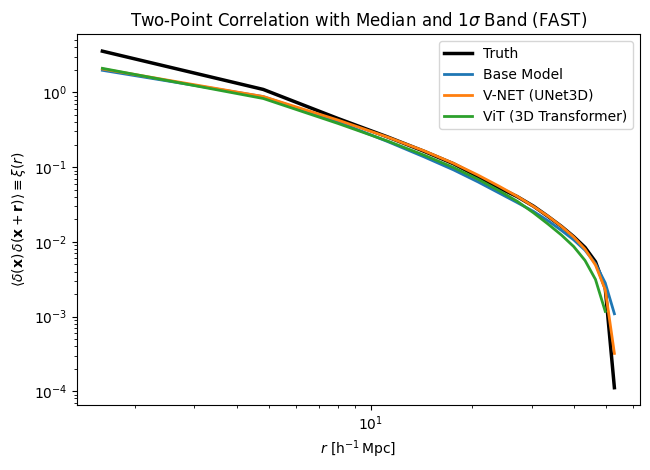

In [5]:
# 2PCF with median line + 1σ band (y: log). Positive-only masking.
import numpy as np
import matplotlib.pyplot as plt

NPZ_PATH = "/home/mingyeong/251105_evaluation/res/structural_consistency_curves_fast.npz"
data = np.load(NPZ_PATH, allow_pickle=True)

models = ["Base Model", "V-NET (UNet3D)", "ViT (3D Transformer)"]
colors = {
    "Base Model": "#1f77b4",
    "V-NET (UNet3D)": "#ff7f0e",
    "ViT (3D Transformer)": "#2ca02c",
}
truth_color = "#000000"  # black

def get(key, default=None):
    return data[key] if key in data else default

def median_band(prefix: str, kind: str):
    """
    prefix: model name (e.g., 'Base Model')
    kind: 'xi_true' or 'xi_pred'
    Returns: r, p50, p16, p84  (any of them may be None if unavailable)
    Priority:
      1) *_samples (shape: [N, R]) -> compute percentiles
      2) *_p16/_p50/_p84 provided
      3) single curve (return p50 only; p16/p84=None)
    """
    r = get(f"{prefix}_r")
    # 1) samples
    samples = get(f"{prefix}_{kind}_samples")
    if samples is not None:
        p16, p50, p84 = np.percentile(samples, [16, 50, 84], axis=0)
        return r, p50, p16, p84
    # 2) precomputed quantiles
    p16 = get(f"{prefix}_{kind}_p16")
    p50 = get(f"{prefix}_{kind}_p50") or get(f"{prefix}_{kind}_median")
    p84 = get(f"{prefix}_{kind}_p84")
    if p50 is not None:
        return r, p50, p16, p84
    # 3) single curve as median-only
    single = get(f"{prefix}_{kind}")
    if single is not None:
        return r, single, None, None
    raise KeyError(f"No {kind} data found for '{prefix}'")

# ---- choose truth reference (to get r grid)
truth_ref = "Base Model"
r_truth, t50, t16, t84 = median_band(truth_ref, "xi_true")

plt.figure(figsize=(6.6, 4.8))

# --- plot TRUTH (band if available)
if t16 is not None and t84 is not None:
    # mask for strict log (positive only)
    m = (t16 > 0) & (t84 > 0) & (t50 > 0)
    plt.fill_between(r_truth[m], t16[m], t84[m], color="#888888", alpha=0.25, label=None)
    plt.plot(r_truth[m], t50[m], color=truth_color, lw=2.5, label="Truth")
else:
    m = t50 > 0
    plt.plot(r_truth[m], t50[m], color=truth_color, lw=2.5, label="Truth")

# --- plot MODELS (prediction band/median)
for mname in models:
    r, p50, p16, p84 = median_band(mname, "xi_pred")
    if p16 is not None and p84 is not None:
        mpos = (p16 > 0) & (p84 > 0) & (p50 > 0)
        plt.fill_between(r[mpos], p16[mpos], p84[mpos], color=colors[mname], alpha=0.25)
        plt.plot(r[mpos], p50[mpos], color=colors[mname], lw=2, label=f"{mname}")
    else:
        mpos = p50 > 0
        plt.plot(r[mpos], p50[mpos], color=colors[mname], lw=2, label=f"{mname}")

plt.xscale("log")
plt.yscale("log")  # strict log, positive xi only (as in your example)
plt.xlabel(r"$r\ \mathrm{[h^{-1}\,Mpc]}$")
plt.ylabel(r"$\langle \delta(\mathbf{x})\,\delta(\mathbf{x}+\mathbf{r}) \rangle \equiv \xi(r)$")
plt.title(r"Two-Point Correlation with Median and $1\sigma$ Band (FAST)")
plt.legend()
plt.tight_layout()
plt.savefig("struct_fast_xi_median_band_log.png", dpi=220)
plt.show()
